In [1]:
# run this command in wsl:

# xhost +local:root

In [2]:
!pip install swig
!pip install gymnasium['box2d']

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count

import gymnasium as gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
env = gym.make("LunarLander-v3", render_mode="human")

In [6]:
is_ipython = 'inline' in matplotlib.get_backend()

if is_ipython:
    from IPython import display

# enable interactive mode
plt.ion()

# setup the device to be used
# all the tensors are to be sent to this device for rendering and manipulation
# in this case video rendering
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# creating subclass of tuple with named fields
# this will be pushed to the replay memory
Transition = namedtuple(typename='Transition', field_names=['state', 'action', 'next_state', 'reward'])

# creating a class to store the memory to be replayed
class ReplayMemory:
    def __init__(self, capacity):
        """
        param: capacity - maximum number of transition the buffer can hold
        """
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        # all the args ['state', 'action', 'next_state', 'reward'] must be pushed to the tensor's devide before stored in memory
        state, action, next_state, reward = args
        state = state.to(device)
        action = action.to(device)
        reward = reward.to(device)
        if next_state is not None:
            next_state = next_state.to(device)

        self.memory.append(Transition(state, action, next_state, reward))

    def sample(self, batch_size):
        # sample the memory buffer
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        # current size of the memory buffer
        return len(self.memory)

In [8]:
class DQN(nn.Module):
    # fully connected NN with 3 layers
    # activation function 'RELU'
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)        

In [9]:
# setting hyperparams
# the size of the batch for sampling from the memory at each training step
# larger size improve stability but increase computational cost
BATCH_SIZE = 256

# starting value of the epsilon
EPS_START = 0.9

# final value of the epsilon
EPS_END = 0.05

# decay rate of the epsilon
# larger value should stabilize the training
EPS_DECAY = 1000

# discount coef
# values close to 1 favor long term rewards
GAMMA = 0.99

# determines how mutch target network is updated against policy network
TAU = 0.005

# learning rate of the agent
LR = 1e-04

In [10]:
n_actions = env.action_space.n

n_observations = env.observation_space.shape[0]

# initialize the policy and target networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

# copy the initial policy network weights to the target network
target_net.load_state_dict(policy_net.state_dict())

# setup the optimizer to be used
optimizer = optim.AdamW(policy_net.parameters(), lr=LR)

# setup the memory with certain amount of records (Transitions)
memory = ReplayMemory(10000)

# to keep track of each episode steps for epsilon decay
step_count = 0 

In [11]:
def take_action(state):
    # the function will return the action to be taken from memory buffer or random from the action space based on the epsilon treshold and the decay of epsilon
    global step_count

    epsilon_treshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * step_count / EPS_DECAY)

    # get a random number to compare to the treshold
    # if the number is bigger - exploit the memory
    # else - explore - get a random action
    # the epsilon will reduce over time so the chance of sample being bigger than epsilon will increase
    sample = random.random()
    # increase the steps count
    step_count += 1
    
    if sample > epsilon_treshold:
        with torch.no_grad():
            # get action from the memory
            return policy_net(state).max(1)[1].view(1, 1) # this returns int, index of the action with maximum reward
    else:        
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long)

In [12]:
# create function to plot the episode duration to monitor learning progress
episode_rewards = []

def plot_rewards(show_result=False):

    # convert the list to np array
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    
    plt.figure(1)
    
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training')

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy(), label='Episode Rewards')

    # Plot moving average of the last 100 episodes
    if len(rewards_t) >= 100:
        # Compute the moving average
        means = rewards_t.unfold(0, 100, 1).mean(1)  # 100-episode window
        means = torch.cat((torch.zeros(99), means))  # Pad with zeros for alignment
        plt.plot(means.numpy(), label='100-Episode Reward Average')
    
    plt.pause(0.001)  # Pause to update the plot in real-time

    # Display in Jupyter/IPython
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())   
    

In [13]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return  # Exit if there are not enough samples in memory to form a batch

    # Sample a batch of transitions from the replay memory
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))  # Convert batch-array of transitions to Transition of batch-arrays

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model's Q-values for the current states and actions
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Initialize tensor for the next state values
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # Compute V(s_{t+1}) for all next states
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Compute expected Q-values
    expected_state_action_values = reward_batch + (GAMMA * next_state_values)

    # Compute Huber loss (Smooth L1 Loss)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()  # Clear the gradients from the previous step
    loss.backward()  # Backpropagate the loss

    # Clip gradients to avoid exploding gradients
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), clip_value=1.0)

    # Perform a single optimization step
    optimizer.step()
    
    

In [14]:
def soft_update_target_network(policy_net, target_net, tau=0.01):
    """
    Perform a soft update of the target network parameters.

    Args:
        policy_net (nn.Module): The policy network whose parameters are used for the update.
        target_net (nn.Module): The target network to be updated.
        tau (float): The soft update coefficient. Values closer to 1.0 mean faster updates.
    """
    for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
        target_param.data.copy_(tau * policy_param.data + (1.0 - tau) * target_param.data)

In [15]:
# training algorithm
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    rewards = 0

    for t in count():
        action = take_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        memory.push(state, action, next_state, reward)

        state = next_state

        # optimize the policy
        optimize_model()

        # soft update
        soft_update_target_network(policy_net, target_net, tau=TAU)
        
        rewards += reward
        if done:
            episode_rewards.append(rewards)
            plot_rewards()
            break
        
        
print('Completed')
plot_rewards(show_result=True)
plt.ioff()
plt.show()

Completed


NameError: name 'plot_durations' is not defined

<Figure size 640x480 with 0 Axes>

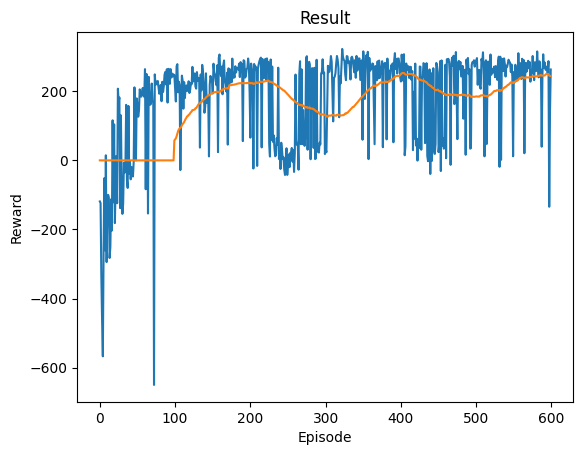

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
plot_rewards(show_result=True)
plt.ioff()
plt.show()

In [37]:
env = gym.make("LunarLander-v3", render_mode="human")
# Reset the environment
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

for t in range(1000):  # Maximum steps for visualization
    with torch.no_grad():
        # Use the trained policy network to select the best action
        action = policy_net(state).max(1)[1].view(1, 1).item()

    # Take the action in the environment
    next_state, reward, terminated, truncated, info = env.step(action)

    # Render the environment
    env.render()    

    # Prepare the next state
    if not terminated:
        state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
    else:
        print(f"Landed for {t+1} steps!")
        break

env.close()

Landed for 256 steps!


In [29]:
# Initialise the environment in human mode
env = gym.make("LunarLander-v3", render_mode="human", continuous=False)

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)
for _ in range(1000):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()


KeyboardInterrupt: 

KeyboardInterrupt: 

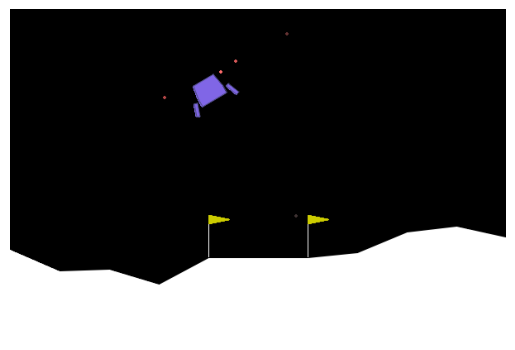

In [38]:
# Initialize the environment with the correct render mode
env = gym.make("LunarLander-v3", render_mode="rgb_array")

# Reset the environment
observation, info = env.reset(seed=42)

# Set up the plot
plt.ion()
fig, ax = plt.subplots()
img = ax.imshow(env.render())
plt.axis('off')  # Hide axes for better visualization

for _ in range(1000):
    # Sample a random action
    action = env.action_space.sample()

    # Step through the environment
    observation, reward, terminated, truncated, info = env.step(action)

    # Render the current frame
    frame = env.render()

    # Ensure the frame is a NumPy array
    if isinstance(frame, np.ndarray):
        img.set_data(frame)
        display.display(fig)
        display.clear_output(wait=True)
    else:
        print("Warning: env.render() did not return a valid frame.")

    # Check if the episode has ended
    if terminated or truncated:
        observation, info = env.reset()

env.close()
